In [67]:
library(dplyr)
library(data.table)
library(ggplot2)
library(forecast)
library(randomForest)
library(party)
library(stringr)
library(e1071)

In [2]:
mapping_classe_kwh <- fread('data/mapping_classe.txt')
mapping_classe_kwh<- mapping_classe_kwh %>%
    mutate(l = lag(kwh)) %>%
    mutate(l = ifelse(is.na(l), -Inf, l))

colnames(mapping_classe_kwh) = c('classe_energetica', 'kwh_ub', 'kwh_lb')

In [3]:
data <- fread('data/immo_data_2020-07-16 20:36:25.447691.csv', quote = '"',sep2="")

Warning message in fread("data/immo_data_2020-07-16 20:36:25.447691.csv", quote = "\"", :
“Found and resolved improper quoting in first 100 rows. If the fields are not quoted (e.g. field separator does not appear within any field), try quote="" to avoid this warning.”


In [4]:
data %>% glimpse()

Observations: 80,565
Variables: 41
$ affitto                <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ regione                <chr> "Emilia Romagna", "Emilia Romagna", "Emilia Ro…
$ provincia              <chr> "Bologna", "Bologna", "Bologna", "Bologna", "B…
$ comune                 <chr> "Bologna", "Bologna", "Dozza", "Bologna", "Cas…
$ id                     <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…
$ url                    <chr> "https://www.immobiliare.it/annunci/81379577/"…
$ url_id                 <int> 81379577, 81378845, 81371441, 81373229, 813784…
$ indirizzo              <chr> "Bologna, Colli San Mamolo, Via San Mamolo", "…
$ latitudine             <dbl> 44.47834, 44.50679, 44.38130, 44.49250, 44.437…
$ longitudine            <dbl> 11.32831, 11.37725, 11.63450, 11.30648, 11.557…
$ titolo                 <chr> "Appartamento via San Mamolo 167, Colli San Ma…
$ sottotitolo            <chr> "S.mamolo–d’azeglio prima collina in posizione…
$ descrizione_bre

In [5]:
data <- data %>% mutate(classe_rimappata = case_when(classe_energetica %in% c('A+', 'A1', 'A2', 'A3', 'A4') ~ 'A+',
                                            T ~ classe_energetica))

In [6]:
mapping_classe_kwh

classe_energetica,kwh_ub,kwh_lb
<chr>,<dbl>,<dbl>
A+,14,-Inf
A,29,14
B,58,29
C,87,58
D,116,87
E,145,116
F,175,145
G,Inf,175


In [19]:
data %>% 
    filter(kwh> 0, superficie > 0) %>%
    mutate(f_kwh = classe_rimappata %in% c('A+', 'A', 'B', 'C', 'D', 'E') & kwh>= 175) %>%
    filter(!f_kwh) %>%
    group_by(classe_rimappata) %>% 
    summarise(n = n(),
              med = median(kwh), 
              avg = mean(kwh), 
             metri_medi = mean(superficie),
             kwh_calcolati = mean(kwh/superficie, na.rm = T))


classe_rimappata,n,med,avg,metri_medi,kwh_calcolati
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
A,523,32.000,37.90400,138.7247,0.3658178
A+,3488,3.510,12.39752,274.6393,0.1325825
B,1026,50.905,50.80577,130.9142,0.6008387
C,1506,78.740,74.18557,194.3207,0.9068895
D,2607,110.000,99.80098,128.3598,1.0999998
E,2836,142.825,122.33566,127.0046,1.3553925
F,7687,175.000,364.24772,204.3698,4.0336679
G,19412,175.000,644.42513,256.6897,12.4856158


In [7]:
tipo_immobile_map <- data %>%
    group_by(tipo_immobile) %>%
    summarise(n = n()) %>%
    mutate(tot = sum(n)) %>%
    mutate(freq = (n/tot)*100) %>%
    ungroup() %>%
    mutate(new_tipo_immobile = ifelse(freq < 0.1, 'Altro', tipo_immobile)) %>%
    pull(new_tipo_immobile)
    #group_by(new_tipo_immobile) %>%
    #summarise(n = sum(n)) %>% 
    #arrange(desc(n))


In [129]:
kwh_data <- data %>% 
    filter(kwh>0.5, kwh < 3000, affitto == 0) %>%
    #filter(kwh>0) %>%
    select(url_id, classe_rimappata, classe_energetica, kwh, superficie, anno_costruzione, locali, tipo_immobile, stato, piano, informazioni_catastali, piani_totali) %>% 
    mutate(classe = ifelse(!str_detect(informazioni_catastali, '(Classe \\w+)'), 'Altro', informazioni_catastali %>% str_extract('(Classe \\w+)'))) %>% 
    select(-informazioni_catastali)
kwh_data = merge(kwh_data, mapping_classe_kwh, by.x = 'classe_rimappata', by.y = 'classe_energetica')

In [130]:
kwh_data<- kwh_data %>% 
    filter(kwh <= kwh_ub, kwh >= kwh_lb) %>%
    filter(kwh != 175) %>%
    filter(superficie>0, anno_costruzione>1700, locali != '', tipo_immobile != '' , superficie < 1000) %>%
    mutate(tipo_immobile = ifelse(tipo_immobile %in% tipo_immobile_map, tipo_immobile, 'Altro')) %>%
    mutate(locali = as.factor(locali), 
          tipo_immobile = as.factor(tipo_immobile), 
          classe_rimappata = as.factor(classe_rimappata),
           classe_energetica = as.factor(classe_energetica),
            classe = as.factor(classe),
           piano = as.factor(piano),
          stato = as.factor(stato)) %>%
    select(-c(kwh_ub, kwh_lb))

kwh_data %>% glimpse

Rows: 10,085
Columns: 12
$ classe_rimappata  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ url_id            <int> 79253965, 78696117, 59203314, 37312242, 81137139, 5…
$ classe_energetica <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ kwh               <dbl> 26.00, 18.00, 20.00, 14.80, 25.57, 25.00, 28.81, 19…
$ superficie        <int> 120, 140, 120, 235, 110, 73, 122, 163, 155, 113, 95…
$ anno_costruzione  <int> 2009, 2020, 2017, 2016, 2010, 2014, 2015, 2014, 201…
$ locali            <fct> 4, 4, 4, 5+, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 2, 5+, 2…
$ tipo_immobile     <fct> Appartamento, Appartamento, Appartamento, Appartame…
$ stato             <fct> Ottimo / Ristrutturato, Nuovo / In costruzione, Nuo…
$ piano             <fct> 3, A, 1, T, 2, 1, A, 2, 3, T, 1, T, , 2, 2, +, 4, 1…
$ piani_totali      <int> 4, 1, 2, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 6, 3, 22,…
$ classe            <fct> Classe A, Classe A, Classe A, Classe A, Classe A, C…


In [131]:
kwh_data %>% group_by(classe_rimappata) %>% summarise(n())

classe_rimappata,n()
<fct>,<int>
A,80
A+,2299
B,366
C,594
D,787
E,543
F,343
G,5073


Le classi A+ e G pesano troppo, le riduco per evitare bias

In [132]:
kwh_data_AP <- kwh_data %>% filter(classe_rimappata == 'A+')
samp_AP <- sample(c(0,1), nrow(kwh_data_AP), prob = c(0.2, 0.8), replace = T)
kwh_data_AP <- kwh_data_AP[samp_AP==0, ]

kwh_data_G <- kwh_data %>% filter(classe_rimappata == 'G')
samp_G <- sample(c(0,1), nrow(kwh_data_G), prob = c(0.1, 0.9), replace = T)
kwh_data_G <- kwh_data_G[samp_G==0, ]

kwh_data_A <- kwh_data %>% filter(classe_rimappata == 'A')

kwh_data_f <- kwh_data %>% filter(!(classe_rimappata %in% c('A+', 'A','G')))

In [134]:
kwh_data <- rbind(kwh_data_A, kwh_data_A, kwh_data_A, kwh_data_A, kwh_data_A, kwh_data_AP, kwh_data_f, kwh_data_G)

In [135]:
kwh_data %>% glimpse()

Rows: 4,011
Columns: 12
$ classe_rimappata  <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ url_id            <int> 79253965, 78696117, 59203314, 37312242, 81137139, 5…
$ classe_energetica <fct> A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, A, …
$ kwh               <dbl> 26.00, 18.00, 20.00, 14.80, 25.57, 25.00, 28.81, 19…
$ superficie        <int> 120, 140, 120, 235, 110, 73, 122, 163, 155, 113, 95…
$ anno_costruzione  <int> 2009, 2020, 2017, 2016, 2010, 2014, 2015, 2014, 201…
$ locali            <fct> 4, 4, 4, 5+, 4, 3, 3, 4, 3, 4, 3, 4, 4, 4, 2, 5+, 2…
$ tipo_immobile     <fct> Appartamento, Appartamento, Appartamento, Appartame…
$ stato             <fct> Ottimo / Ristrutturato, Nuovo / In costruzione, Nuo…
$ piano             <fct> 3, A, 1, T, 2, 1, A, 2, 3, T, 1, T, , 2, 2, +, 4, 1…
$ piani_totali      <int> 4, 1, 2, 3, 2, 4, 2, 3, 2, 2, 2, 2, 2, 2, 6, 3, 22,…
$ classe            <fct> Classe A, Classe A, Classe A, Classe A, Classe A, C…


In [136]:
kwh_data %>% group_by(classe_rimappata) %>% summarise(n())

classe_rimappata,n()
<fct>,<int>
A,400
A+,463
B,366
C,594
D,787
E,543
F,343
G,515


In [137]:
train_perc = .7
train_ix <- sample(1:nrow(kwh_data), as.integer(nrow(kwh_data)*train_perc))
test_ix <- setdiff(1:nrow(kwh_data), train_ix)

In [138]:
train_set <- kwh_data[train_ix, ]
test_set <- kwh_data[test_ix, ]

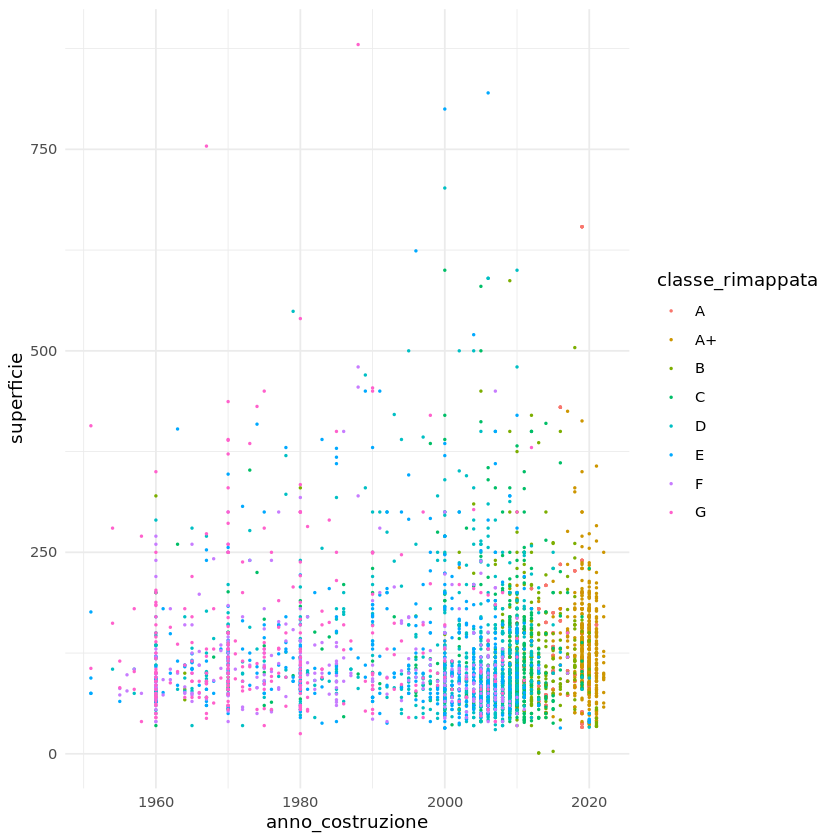

In [139]:
ggplot(kwh_data %>% filter(anno_costruzione > 1950, kwh < 300) , aes(x=anno_costruzione, y=superficie)) + 
  geom_point(aes(color=classe_rimappata), size = 0.3) +
    theme_minimal()

In [67]:
#mod <- lm(kwh ~ -1 + anno_costruzione + tipo_immobile + stato + superficie, data = train_set) #### PAPABILE
#mod <- randomForest(kwh  ~ anno_costruzione + tipo_immobile + locali + stato + superficie, data = train_set)

#mod <- lm(classe_rimappata ~ superficie + anno_costruzione + piani_totali, data = train_set)

#mod <- svm(classe_rimappata ~ superficie + anno_costruzione + prezzo, data = train_set, scale = FALSE, kernel = "radial", cost = 10, gamma = 1)


In [140]:
param_grid = expand.grid(c(0.001, 0.01, 0.1, 1, 10, 100, 1000), c(0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100)) %>% data.frame()

colnames(param_grid)<- c('C', 'gamma')

best_param <- list('C'=0, 'gamma'=0, 'prec'=0)

for(i in 1:nrow(param_grid)){
    
    mod <- svm(classe_rimappata ~ superficie + anno_costruzione, data = train_set, 
               scale = F,
               kernel = "radial", 
               cost = param_grid$C[i], 
               gamma = param_grid$gamma[i])
    
    pred <- predict(mod, test_set)

    test_set$classe_pred <- pred

    #test_set %>% select(classe_rimappata, classe_pred) %>% table %>% print()


    corrette = test_set %>% filter(classe_rimappata == classe_pred) %>% nrow()
    totali = nrow(test_set)
    
    if(corrette/totali > best_param$prec) {
        best_param$C <- param_grid$C[i]
        best_param$gamma <- param_grid$gamma[i]
        best_param$prec <- corrette/totali
    }
    
    message('C: ', param_grid$C[i], ' - gamma: ', param_grid$gamma[i], ' - Precisione: ',corrette/totali)
}

C: 0.001 - gamma: 1e-05 - Precisione: 0.200996677740864

C: 0.01 - gamma: 1e-05 - Precisione: 0.200996677740864

C: 0.1 - gamma: 1e-05 - Precisione: 0.217607973421927

C: 1 - gamma: 1e-05 - Precisione: 0.323920265780731

C: 10 - gamma: 1e-05 - Precisione: 0.361295681063123

C: 100 - gamma: 1e-05 - Precisione: 0.387873754152824

C: 1000 - gamma: 1e-05 - Precisione: 0.404485049833887

C: 0.001 - gamma: 1e-04 - Precisione: 0.200996677740864

C: 0.01 - gamma: 1e-04 - Precisione: 0.200996677740864

C: 0.1 - gamma: 1e-04 - Precisione: 0.314784053156146

C: 1 - gamma: 1e-04 - Precisione: 0.352990033222591

C: 10 - gamma: 1e-04 - Precisione: 0.411129568106312

C: 100 - gamma: 1e-04 - Precisione: 0.417774086378738

C: 1000 - gamma: 1e-04 - Precisione: 0.417774086378738

C: 0.001 - gamma: 0.001 - Precisione: 0.200996677740864

C: 0.01 - gamma: 0.001 - Precisione: 0.200996677740864

C: 0.1 - gamma: 0.001 - Precisione: 0.341362126245847

C: 1 - gamma: 0.001 - Precisione: 0.406976744186047

C: 10 -

In [141]:
best_param

$C
[1] 10

$gamma
[1] 0.001

$prec
[1] 0.4186047

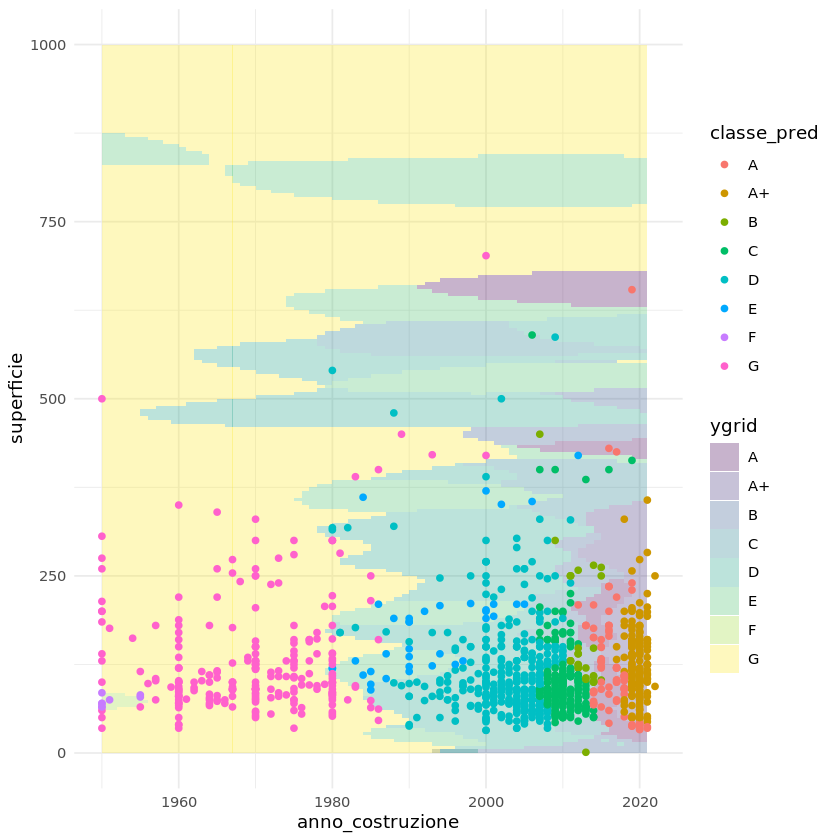

In [142]:
mod <- svm(classe_rimappata ~ superficie + anno_costruzione, data = train_set, 
               scale = F, 
               kernel = "radial", 
               cost = 10, #1000, 
               gamma = 0.001)#0.0001)

xgrid = expand.grid(seq(1950, 2021, 1), seq(0, 1000, 5)) %>% data.frame()
xgrid =  xgrid %>% rename(anno_costruzione = Var1, superficie = Var2)
ygrid = predict(mod, xgrid)
pred_grid = data.frame(xgrid, ygrid = factor(ygrid, levels = levels(test_set$classe_rimappata), ordered = T))

pred <- predict(mod, test_set)
test_set$classe_pred <- pred

ggplot() + 
  geom_bin2d(data = pred_grid, aes(x=anno_costruzione, y=superficie, fill=ygrid), alpha = 0.3, binwidth = c(1, 5)) +
    geom_point(data = test_set %>% filter(anno_costruzione>=1950), aes(x = anno_costruzione, y = superficie, color = classe_pred)) + 
    theme_minimal()

In [76]:
pred <- predict(mod, test_set)

test_set$classe_pred <- pred

test_set %>% select(classe_rimappata, classe_pred) %>% table %>% print()


corrette = test_set %>% filter(classe_rimappata == classe_pred) %>% nrow()
totali = nrow(test_set)

corrette / totali

                classe_pred
classe_rimappata   A  A+   B   C   D   E   F   G
              A    0   7   5   9   2   0   0   0
              A+   0 119   2   5   0   0   0   4
              B    0  17  20  65   5   1   0   5
              C    0   6   7  87  52   3   1  17
              D    0   0   6  66 116  23   2  43
              E    0   3   1  13  80  10   4  49
              F    0   0   1   4  32   6   2  59
              G    0   1   0   7  12   9   2 107


[1] 0.420237

[1] 1.973669


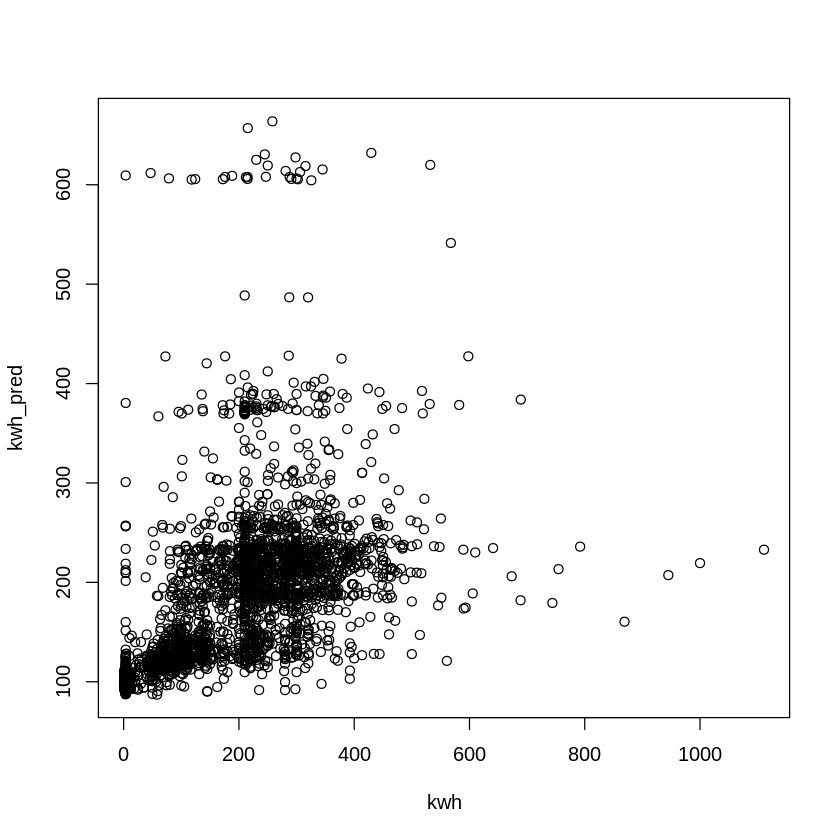

In [185]:
predict <- predict(object = mod, newdata = test_set %>% select(superficie, anno_costruzione, tipo_immobile, stato, piani_totali), type = 'response')
test_set$kwh_pred <- predict
res = test_set %>% mutate(r = (kwh-kwh_pred)^2) %>% pull(r) 

print((mean(res)/length(res)) %>% sqrt)

test_set %>% select(kwh, kwh_pred) %>% plot()

#### KERAS MODEL

In [100]:
library(keras)
b <- dataset_mnist()

In [131]:
X_train = train_set %>% select(anno_costruzione, superficie) %>% as.matrix
y_train = train_set %>% pull(classe_rimappata) %>% as.integer

In [132]:
X_train = array_reshape(X_train, c(nrow(X_train), 2))
y_train <- to_categorical(y_train, num_classes = 0)

In [163]:
model <- keras_model_sequential()

model %>%
    layer_dense(units = 30, input_shape = c(2)) %>%
    layer_dense(units = 15) %>%
    layer_dense(units = 9, activation = 'softmax')

In [164]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_15 (Dense)                    (None, 30)                      90          
________________________________________________________________________________
dense_16 (Dense)                    (None, 15)                      465         
________________________________________________________________________________
dense_17 (Dense)                    (None, 9)                       144         
Total params: 699
Trainable params: 699
Non-trainable params: 0
________________________________________________________________________________


In [165]:
model %>% compile(
    loss = 'categorical_crossentropy',
    optimizer = optimizer_rmsprop(),
    metrics = c('accuracy')
)

In [166]:
history <- model %>% fit(
    X_train, y_train, 
    epochs = 30, batch_size = 8, 
    validation_split = 0.2
)

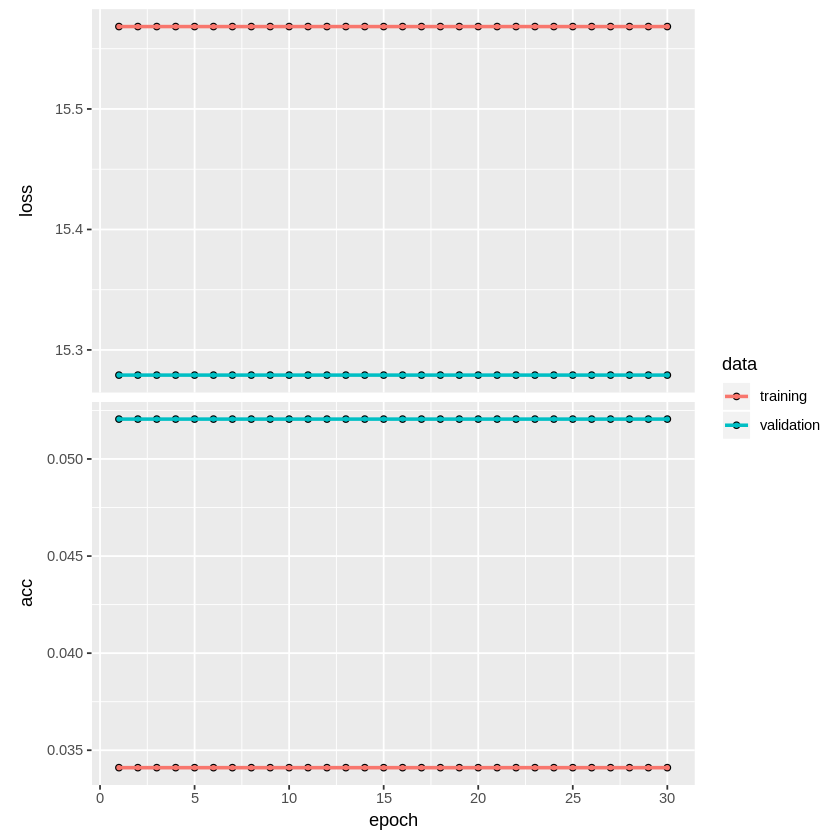

In [167]:
plot(history)